In [45]:
import tensorflow as tf
import coco_helper as ch
from config import *
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return 

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [14]:
def serialize_example(idd,image_raw,size,kpts,joints):
    
    kpts=kpts.tobytes()
    joints=joints.tobytes()
    
    feature = {
        'id': _int64_feature(idd),
        'image_raw': _bytes_feature(image_raw),
        'size': tf.train.Feature(float_list=tf.train.FloatList(value=size)),
        'kpts': _bytes_feature(kpts),
        'joints': _bytes_feature(joints),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [5]:
with open(TRANSFORMED_TRAIN_ANNOTATIONS_PATH, 'rb') as f:
    combined_dict = pickle.load(f)

In [ ]:
filename="./dataset/transformed/coco_keypoints-001.tfrecords"
writer= tf.io.TFRecordWriter(filename)
count=0
for idd,l in combined_dict.items():
    size=l[0]
    kpts=l[1]
    joints=l[2]
    
    image_raw=tf.io.read_file(ch.id_to_filename(idd))
    
    example = serialize_example(idd,image_raw,size,kpts,joints)
    writer.write(example)
    
    count+=1
    if not count%100: print(".",end="")
    if not count%1000:
        writer.flush()
        writer.close()
        filename=f"./dataset/transformed/coco_keypoints-{int(count/1000):03}.tfrecords"
        writer= tf.io.TFRecordWriter(filename)
        print("|",end="")
writer.flush()
writer.close()       

In [3]:
tfrecord_files=glob.glob(TRANSFORMED_TRAIN_ANNOTATIONS_PATH+"-*.tfrecords")

In [4]:
raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

In [41]:
feature_description = {
    'id': tf.io.FixedLenFeature([1], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'size': tf.io.FixedLenFeature([2], tf.int64),
    'kpts': tf.io.FixedLenFeature([], tf.string),
    'joints': tf.io.FixedLenFeature([], tf.string)
}
@tf.function
def read_tfrecord(serialized_example,decode_jpg=True):
    parsed= tf.io.parse_single_example(serialized_example, feature_description)

    idd = parsed['id']
    image_raw = parsed['image_raw']
    
    if decode_jpg:
        image_raw=tf.image.decode_jpeg(image_raw)
    
    size = parsed['size']
    kpts= tf.io.parse_tensor(parsed['kpts'],tf.float32)
    joints= tf.io.parse_tensor(parsed['joints'],tf.float32)
    
    kpts=tf.RaggedTensor.from_tensor(kpts)
    joints=tf.RaggedTensor.from_tensor(joints)
    
    return {"id":idd, "image_raw":image_raw, "size":size, "kpts":kpts,"joints":joints}

In [42]:
parsed_dataset=raw_dataset.map(read_tfrecord)
parsed_dataset

<MapDataset shapes: {id: (1,), image_raw: (None, None, None), size: (2,), kpts: <unknown>, joints: <unknown>}, types: {id: tf.int64, image_raw: tf.uint8, size: tf.int64, kpts: tf.float32, joints: tf.float32}>

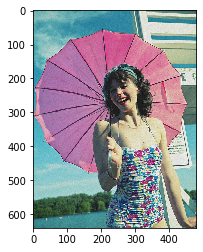

In [46]:
sample=next(iter(parsed_dataset.take(1)))
plt.imshow(sample['image_raw'])

In [22]:
def parse_kpts(first_stage):
    kpts=first_stage['kpts']
    kpts_t=tf.io.parse_tensor(kpts,tf.float32)
    first_stage['kpts']=kpts_t
    return first_stage

In [23]:
second_tage_dataset=parsed_dataset.map(parse_kpts)
second_tage_dataset

<MapDataset shapes: {id: (), image_raw: (), joints: (), kpts: <unknown>, size: (2,)}, types: {id: tf.int64, image_raw: tf.string, joints: tf.string, kpts: tf.float32, size: tf.int64}>

In [25]:
sample=next(iter(second_tage_dataset.take(1)))
sample

{'id': <tf.Tensor: id=210, shape=(), dtype=int64, numpy=36>,
 'image_raw': <tf.Tensor: id=211, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xf0\x00\xf0\x00\x00\xff\xe2\x02@ICC_PROFILE\x00\x01\x01\x00\x00\x020ADBE\x02\x10\x00\x00mntrRGB XYZ \x07\xcf\x00\x06\x00\x03\x00\x00\x00\x00\x00\x00acspAPPL\x00\x00\x00\x00none\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-ADBE\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ncprt\x00\x00\x00\xfc\x00\x00\x002desc\x00\x00\x010\x00\x00\x00kwtpt\x00\x00\x01\x9c\x00\x00\x00\x14bkpt\x00\x00\x01\xb0\x00\x00\x00\x14rTRC\x00\x00\x01\xc4\x00\x00\x00\x0egTRC\x00\x00\x01\xd4\x00\x00\x00\x0ebTRC\x00\x00\x01\xe4\x00\x00\x00\x0erXYZ\x00\x00\x01\xf4\x00\x00\x00\x14gXYZ\x00\x00\x02\x08\x00\x00\x00\x14bXYZ\x00\x00\x02\x1c\x00\x00\x

In [198]:
a=np.frombuffer(sample['kpts'].numpy(),dtype=np.float32)

In [208]:
arr=np.arange(100,dtype=np.float32).reshape(5,2,10)
np.frombuffer(arr.tobytes(),dtype=np.float32)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.], dtype=float32)

In [134]:
def int64_feature(value):
    if type(value) != list:
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def float_feature(value):
    if type(value) != list:
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

writer = tf.io.TFRecordWriter('file.tfrecords')
bytes = np.random.random((10,10)).tobytes() 
int = 1
float = 1.1
example = tf.train.Example(features=tf.train.Features(feature={'1': bytes_feature(bytes)}))
writer.write(example.SerializeToString())
writer.close()

for str_rec in tf.compat.v1.io.tf_record_iterator('file.tfrecords'):
    example = tf.train.Example()
    example.ParseFromString(str_rec)
    str = (example.features.feature['1'].bytes_list.value[0])
    
    print(str)
    print(np.frombuffer(str))

b'\xfa\x14\xe0U\xf7b\xdf?,-\xc98\xbf\xdd\xe7?\x00\xd7\xa4\x06\x97K\xd9?\xa8)\xd4\'\x80|\xca?J!\t\xd5,\xc5\xd2?&\xebe\xba\xfa\xe4\xde?\xc0\x04<9\x18O\xc8?PX\xefQQo\xeb?\xa0\x94x\xe1d\x95\x92?\xe2\tld\xf6\x80\xe5?\x8c\xc7\x8am\x83\xde\xe2?\xe4,YO\xdc\xa6\xc3?x\xdb\xf4\x92\x96\xc6\xc7?^;\xf6\rg\x97\xd5?xu\x89RO\xbc\xcd?\x98[^\xa0\xf0\xd6\xb3?\xf4\x95\xfam\xf7W\xe6?\xc0\xe8\xaf\xf6\x8a2\x8a?\xb8x\xba\x98rb\xbb?\x00:\xf9\r\x1f\x98\xe9?\xf9jYW\x00\xf2\xe3?\xd0b\xff\xe9{\xbb\xa3?\xf9E\xe1\xc4Q\xc6\xe3?\xa8\xcc\x87\xeb\x06T\xe2?]Bk}\xac\xe0\xea?o\x03Y\x85\x17\xef\xe9?S\xcb6\xa9\xa6\x97\xe3?r\x9c\x7f\xe6\xc2W\xd0?x>\xf0\xd4\xcc\x14\xc2?\x06\x0c\xdaT\x8b\x8a\xe0?PtaEt\xfe\xdc?J\xb4\x11\xc2^h\xed?\xa0W\xba\xfc\xc7\xd1\x91?T\xeaB\x94\xb9\x00\xca?\x00\x92e\xd3C\xe6Y?\xf8\xb6\xb4Y\'b\xe1?\x0b\x83\x80\xa60\xf8\xec?\x83\xb3\x14l\xbdO\xee?\xd0r\x87B\xf6\xd3\xbe?\xcc\'(;\xf4@\xd7?\x06n\xc9\x0f%\x93\xd7?0\x8c\xc2\xf8t\xa6\xda?\x81\xc4\x9e-\x85\x08\xec?\xa4\xbd\x80\x89*\xff\xc2?\xdex\xa0{\xad)\xee?\x1d\x0

In [140]:
feature_description_t = {    '1': tf.io.FixedLenFeature([], tf.string)}

def read_tfrecord_t(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description_t)

raw_dataset_t = tf.data.TFRecordDataset(['file.tfrecords'])

In [151]:
raw_dataset_t=raw_dataset_t.map(read_tfrecord_t)
raw_dataset_t

<MapDataset shapes: {1: ()}, types: {1: tf.string}>

In [155]:
s=next(iter(raw_dataset_t.take(1)))['1'].numpy()
np.frombuffer(s)

array([0.49041541, 0.74581872, 0.39523864, 0.20692446, 0.29328461,
       0.48272579, 0.18991378, 0.85733858, 0.01814802, 0.67199249,
       0.58966228, 0.15352968, 0.18574793, 0.33736588, 0.23230926,
       0.07749847, 0.6982381 , 0.01279172, 0.10697094, 0.7998195 ,
       0.62329118, 0.03853976, 0.61795891, 0.57275721, 0.839926  ,
       0.81043602, 0.61226209, 0.25535653, 0.14125977, 0.51691214,
       0.45303065, 0.9189905 , 0.01740181, 0.20314712, 0.00158078,
       0.54323165, 0.90529664, 0.94723388, 0.12042178, 0.36333948,
       0.368356  , 0.41640972, 0.87604007, 0.14841205, 0.94258761,
       0.89482125, 0.52210778, 0.41134548, 0.0983628 , 0.15210055,
       0.98960659, 0.11304313, 0.14974745, 0.86147983, 0.4975239 ,
       0.36416012, 0.49364628, 0.89489034, 0.90891387, 0.56493727,
       0.12368609, 0.89516224, 0.73385753, 0.22239974, 0.8480263 ,
       0.09424564, 0.84330319, 0.82638894, 0.55650724, 0.19810661,
       0.06821282, 0.99951703, 0.54722389, 0.40186513, 0.84327

In [209]:
import pickle

In [214]:
s=pickle.dumps([np.arange(100).reshape(10,10)])

In [215]:
pickle.loads(s)

[array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])]

In [222]:
with open(f'./dataset/trainval2017/{110:012}.jpg','rb') as f:
    bv=f.read()

In [224]:
tf.image.decode_jpeg(bv)

<tf.Tensor: id=139766, shape=(480, 640, 3), dtype=uint8, numpy=
array([[[ 23,  25,  24],
        [ 32,  32,  32],
        [ 27,  23,  24],
        ...,
        [ 74,  45,  47],
        [ 73,  39,  40],
        [ 63,  24,  27]],

       [[ 18,  22,  21],
        [ 29,  31,  30],
        [ 27,  25,  28],
        ...,
        [ 77,  45,  48],
        [ 76,  46,  46],
        [ 59,  31,  28]],

       [[ 20,  26,  26],
        [ 20,  24,  27],
        [ 24,  23,  28],
        ...,
        [ 81,  47,  48],
        [ 89,  53,  53],
        [ 71,  32,  33]],

       ...,

       [[215, 225, 217],
        [214, 225, 217],
        [217, 229, 219],
        ...,
        [ 97,  99,  88],
        [105, 104,  83],
        [102, 101,  71]],

       [[216, 225, 220],
        [217, 226, 221],
        [215, 226, 218],
        ...,
        [103, 104,  86],
        [102, 102,  90],
        [ 99,  99,  91]],

       [[213, 219, 217],
        [206, 215, 210],
        [210, 221, 213],
        ...,
        [1